1. Loading images
2. Registering dataset (Dataloader)
3. Training the network

(detectron2 colab) https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=dq9GY37ml1kr

(mango) 
https://wendeehsu.medium.com/instance-segmentation-with-detectron2-127fbe01b20b

(Hazelnut)
https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/

## Loading images

******Must check if masks will show up as well

In [5]:
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 8.1.1


In [6]:
from PIL import Image
# open the image from working directory
image1 = Image.open('/home/gskl92/dsmcer/datayoink/DataYoink/Photos/E12_1.PNG')
# summarize some details about the image
print(image1.format)
print(image1.size)
print(image1.mode)
# show the image
image1

#repeat for image 2 and 3
image2 = Image.open('/home/gskl92/dsmcer/datayoink/DataYoink/Photos/E12_2.PNG')
image3 = Image.open('/home/gskl92/dsmcer/datayoink/DataYoink/Photos/E12_3.PNG')


PNG
(991, 825)
RGBA


In [7]:
image1, image2, image3

(<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=991x825 at 0x7FA070837E80>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=950x892 at 0x7FA070837460>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1079x1061 at 0x7FA070837EB0>)

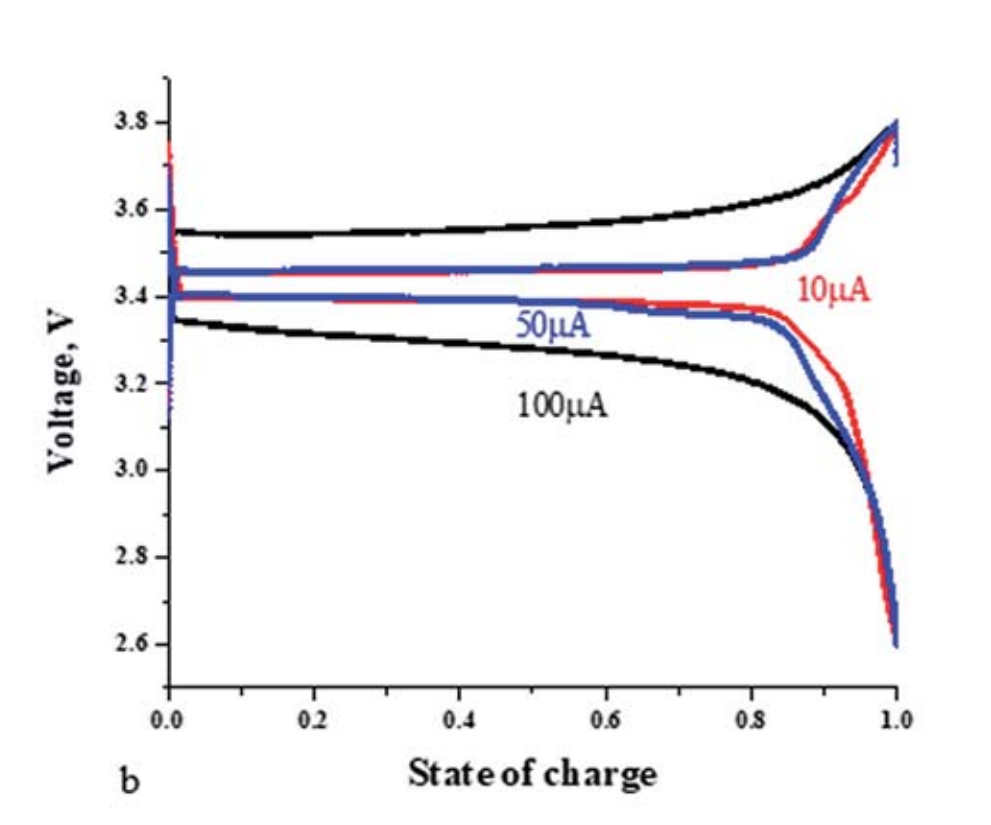

In [8]:
image1

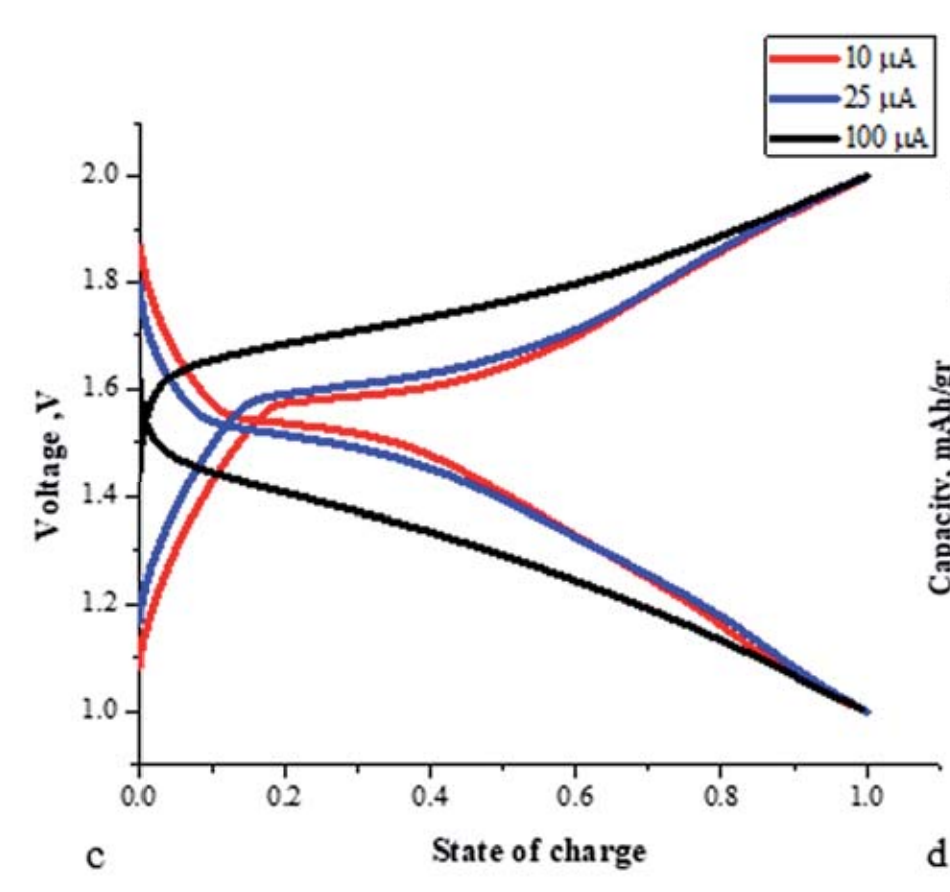

In [6]:
image2

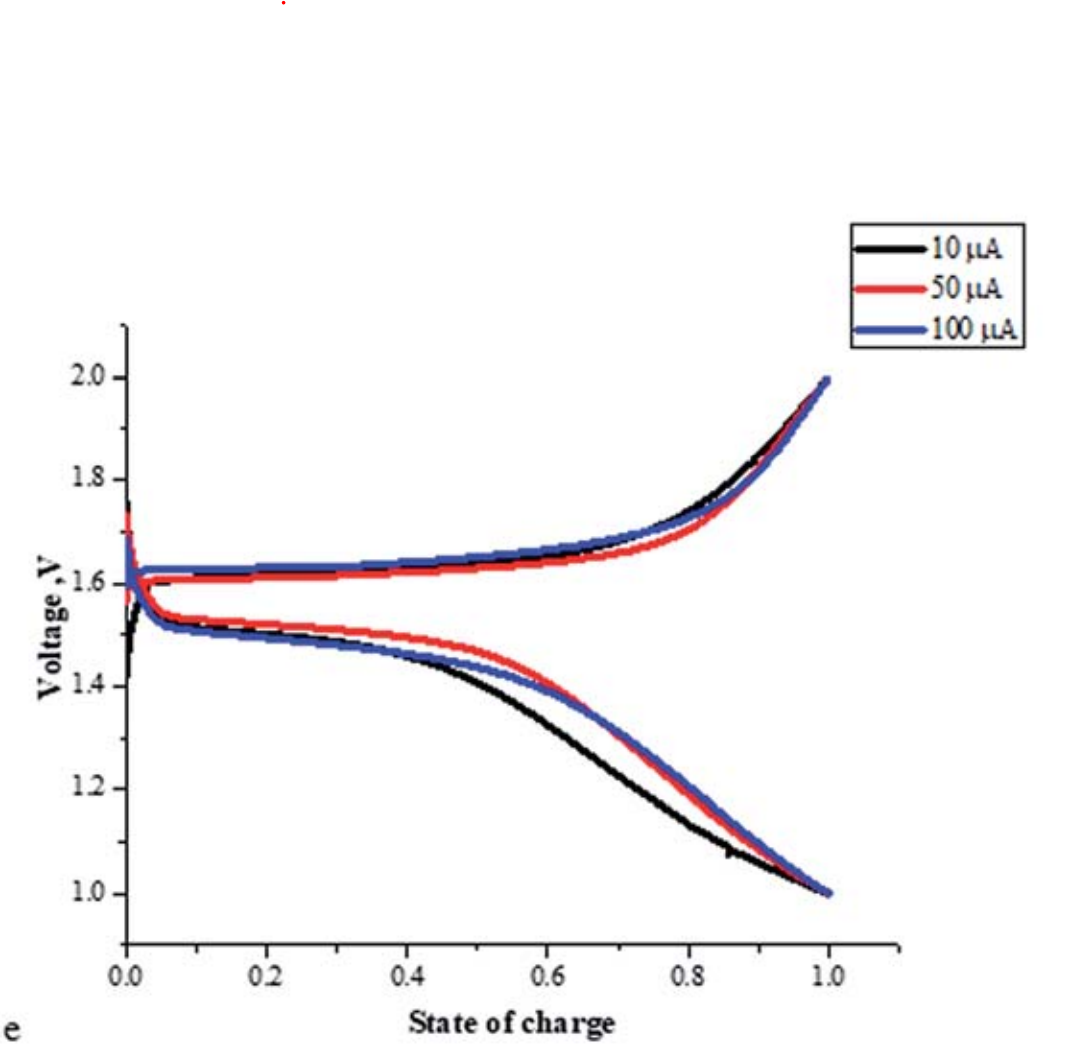

In [7]:
image3

## Using OpenCV to upload and matplotlib to show

Seems to not work as well
https://www.reddit.com/r/Python/comments/4u7qlu/pillow_vs_opencv/

In [2]:
from cv2 import *
print(cv2.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

4.5.1


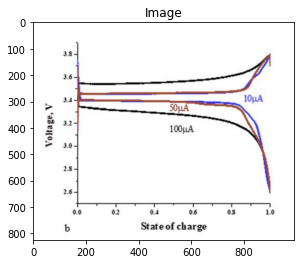

In [3]:
im = cv2.imread('/home/gskl92/dsmcer/datayoink/DataYoink/Photos/E12_1.PNG')
plt.imshow(im)
plt.title('Image')
plt.show()

## Register Dataset/ Dataloader

Transforming our annotations into the form that detectron2 can take as input

In [4]:
def get_dicts(img_dir): #(img_dir)
    json_file = os.path.join(img_dir, 'Users\Kevin\Desktop\DIRECT 525\DataYoinkDischargeCurves\DischargeCurve_annotatedexample1.json') #(img_dir) (via_export_json.json) (jason_file)
    with open(json_file) as f: #(jason_file)
        imgs_anns = json.load(f) #(imgs_anns)
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()): # (idx)* (v)
        record = {}
        
        filename = os.path.join(img_dir, v["filename"]) #(filename) (img_dir) (v)
        height, width = cv2.imread(filename).shape[:2] #(filename)
        
        record["file_name"] = filename #(filename)
        record["image_id"] = idx #(idx)*
        record["height"] = height 
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)], #(bbox)
                "bbox_mode": BoxMode.XYXY_ABS, #(bbox_mode)
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
                }
            objs.append(obj)
            print(objs)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

"""
As I only have 1 class (mango), the category_id is set to 0

iscrowd is 0 because our mango detection is a single object segmentation



"""

'\nAs I only have 1 class (mango), the category_id is set to 0\n\niscrowd is 0 because our mango detection is a single object segmentation\n\n\n\n'

In [ ]:
"""
To tell detectron2 how to access our dataset, we need to register them by:
"""

from detectron2.data import DatasetCatalog, MetadataCatalog
path = "/content/drive/.../wendee/images" # path to your image folder
for d in ["train", "val"]:
    DatasetCatalog.register("..." + d, lambda d=d: get_dicts(path + "/" +  d))
    MetadataCatalog.get("..." + d).set(thing_classes=["..."])
    

In [10]:
"""
After registering, we can check whether our data can be loaded correctly by using a handy visualizaer.
Instead of using cv2, I need to check if PIL(pillow) works for this

"""

import random
from detectron2.utils.visualizer import Visualizer
dataset_dicts = get_dicts(path + "train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("DischargeCurve_train"), scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

NameError: name 'path' is not defined

## Training the network

In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

#Need to read over and document what the above APIs do.

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/.../wendee/detectMango" #Where I want the output to be downloaded
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) #Name of the model we will be using. This can be decided later depending on how this goes

In [12]:
cfg.DATASETS.TRAIN = ("DischargeCurve_train",)     # our training dataset
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2     # number of parallel data loading workers
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")     # use pretrained weights
cfg.SOLVER.IMS_PER_BATCH = 2     # in 1 iteration the model sees 2 images
cfg.SOLVER.BASE_LR = 0.00025     # learning rate
cfg.SOLVER.MAX_ITER = 450        # number of iteration
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128     # number of proposals to sample for training
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (mango)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

PermissionError: [Errno 13] Permission denied: '/content'

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/.../wendee/detectMango"